In [1]:
# the source graph was prepared using the map taken from:
# https://github.com/pszufe/OpenStreetMapX.jl/blob/master/test/data/reno_east3.osm

## path to datasets
datadir='../Datasets/'

In [2]:
import folium as flm 
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Major limitations of the simplified simulation
* real road graphs are directed
* we ignore road length
* we ignore number of lains
* we ignore speed limits
* we ignore restrictions on turning on intersections
* we ignore road usage restrictions
* we ignore road class
* we assume uniform source and destination locations

In [3]:
g = ig.read(datadir+'Reno/reno.dat', directed=False).simplify()

In [4]:
meta = pd.read_csv(datadir+'Reno/nodeloc.csv')

In [5]:
g.vs['longitude'] = list(meta['lon'])
g.vs['latitude'] = list(meta['lat'])
g.vs['layout'] = [(v['longitude'],v['latitude']) for v in g.vs]

In [6]:
g = g.clusters().giant()

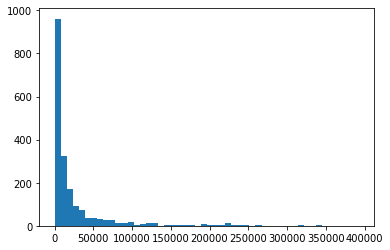

In [7]:
plt.hist(g.betweenness(), 50);

In [8]:
very_heavy_usage = np.quantile(g.betweenness(), 0.99)
heavy_usage = np.quantile(g.betweenness(), 0.9)

In [9]:
bet = g.betweenness()
g.vs['color'] = ["black" if b < heavy_usage else "violet" if b < very_heavy_usage else "red" for b in bet]
g.vs['size'] = [3 if b < heavy_usage else 5 if b < very_heavy_usage else 8 for b in bet]

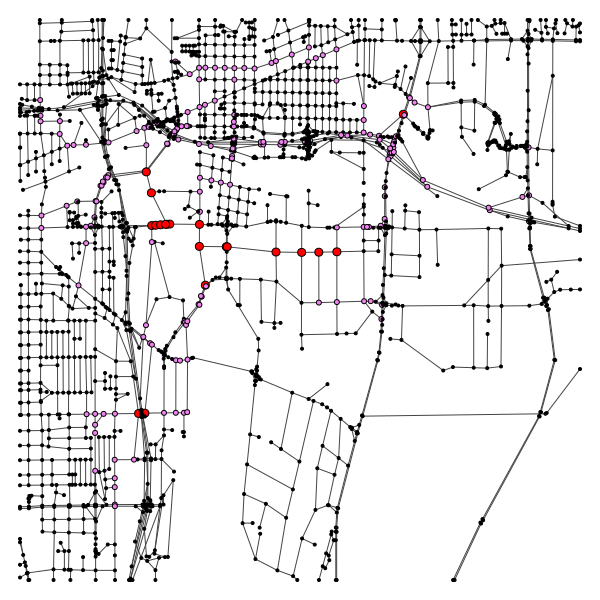

In [10]:
ly = ig.Layout(g.vs['layout'])
ly.mirror(1)
ig.plot(g, layout=ly, vertex_size=g.vs['size'], vertex_color=g.vs['color'], edge_arrow_size=0.7, edge_arrow_width=0.7)

When we do map overlay we note that there is a river in the middle of the plot going from west to east.

In [11]:
MAP_BOUNDS = ((39.5001-0.001, -119.802-0.001), (39.5435+0.001, -119.7065+0.001))
m_plot = flm.Map()

for v in g.vs:
    flm.Circle(
        (v['latitude'], v['longitude']),
        radius=10, color=v['color'], weight= v['size'],
        fill=True, fill_color=v['color']).add_to(m_plot)

for e in g.es:
    v1 = g.vs[e.source]
    v2 = g.vs[e.target]
    flm.PolyLine(
        [(v1['latitude'], v1['longitude']), (v2['latitude'], v2['longitude'])],
        color="black", weight=1).add_to(m_plot)

flm.Rectangle(MAP_BOUNDS, color="blue",weight=4).add_to(m_plot)
m_plot.fit_bounds(MAP_BOUNDS)
m_plot